In [20]:
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import lightgbm as lgb
import matplotlib.pyplot as plt
import joblib

In [21]:
df = pd.read_csv("../data_lightgbm/cleaned_race_results_for_lightgbm.csv")
race_counts = df["race_id"].value_counts()
valid_races = race_counts[race_counts == 16].index
df_16 = df[df["race_id"].isin(valid_races)]
#1012 valid races

In [22]:
selected_features = ["total_weight", 
                     "speed_mps", 
                     "avg_speed_mps", 
                     "favorite", 
                     "bracket_number", 
                     "age", 
                     "top3", 
                     "track_distance", 
                     "weather_weather01", 
                     "weather_weather02"
                     ]

In [23]:
unique_races = df_16["race_id"].unique()
train_races, test_races = train_test_split(unique_races, test_size=0.2, random_state=42)
#train races: 809, test races: 203
df_train = df_16[df_16["race_id"].isin(train_races)]
df_test = df_16[df_16["race_id"].isin(test_races)]



In [24]:
def generate_pairwise_df(df_grouped):
    rows = []
    for race_id, group in df_grouped.groupby("race_id"):
        group = group.reset_index(drop=True)
        for i, j in combinations(range(len(group)), 2):
            hi = group.loc[i]
            hj = group.loc[j]

            diff = hi[selected_features].values - hj[selected_features].values
            target = int(hi["finish_position"] < hj["finish_position"])
            rows.append(np.concatenate([diff, [target], [race_id], [hi["horse_id"]]]))

            diff_rev = hj[selected_features].values - hi[selected_features].values
            target_rev = int(hj["finish_position"] < hi["finish_position"])
            rows.append(np.concatenate([diff_rev, [target_rev], [race_id], [hj["horse_id"]]]))
    
    return pd.DataFrame(rows, columns=[f"{col}_diff" for col in selected_features] + ["target", "race_id", "horse_id"])
#combinations: 120 * 2


In [25]:
pairwise_train_df = generate_pairwise_df(df_train)
pairwise_test_df = generate_pairwise_df(df_test)

In [26]:
X_train = pairwise_train_df.drop(columns=["target", "race_id", "horse_id"])
y_train = pairwise_train_df["target"]
X_test = pairwise_test_df.drop(columns=["target", "race_id", "horse_id"])
y_test = pairwise_test_df["target"]
test_race_ids = pairwise_test_df["race_id"].values
test_horse_ids = pairwise_test_df["horse_id"].values



In [27]:
X_model, X_cali, y_model, y_cali = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
base_model = lgb.LGBMClassifier(objective='binary', is_unbalance=True, random_state=42)
base_model.fit(X_model, y_model)
calibrated_model = CalibratedClassifierCV(base_model, method='isotonic', cv='prefit')
calibrated_model.fit(X_cali, y_cali)

[LightGBM] [Info] Number of positive: 78162, number of negative: 78318
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 836
[LightGBM] [Info] Number of data points in the train set: 156480, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499502 -> initscore=-0.001994
[LightGBM] [Info] Start training from score -0.001994


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


CalibratedClassifierCV(cv='prefit',
                       estimator=LGBMClassifier(is_unbalance=True,
                                                objective='binary',
                                                random_state=42),
                       method='isotonic')

In [28]:
proba = calibrated_model.predict_proba(X_test)[:, 1]
result_df = pd.DataFrame({
    "race_id": test_race_ids,
    "horse_id": test_horse_ids,
    "proba": proba
})

In [29]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

result_df["softmax_proba"] = result_df.groupby("race_id")["proba"].transform(softmax)
result_df["rank"] = result_df.groupby("race_id")["softmax_proba"].rank(ascending=False, method="first")
top1_df = result_df[result_df["rank"] == 1]

In [30]:
true_labels_df = df_test[["race_id", "horse_id", "finish_position"]].copy()
true_labels_df["target"] = (true_labels_df["finish_position"] == 1).astype(int)

predicted_labels_df = result_df[["race_id", "horse_id", "rank"]].copy()
predicted_labels_df["predicted"] = (predicted_labels_df["rank"] == 1).astype(int)
print(predicted_labels_df)

merged_all = true_labels_df.merge(predicted_labels_df[["race_id", "horse_id", "predicted"]], on=["race_id", "horse_id"], how="left")
merged_all["predicted"] = merged_all["predicted"].fillna(0).astype(int)

            race_id      horse_id   rank  predicted
0      1.990030e+11  1.987106e+09    1.0          1
1      1.990030e+11  1.986102e+09  122.0          0
2      1.990030e+11  1.987106e+09    2.0          0
3      1.990030e+11  1.985107e+09  123.0          0
4      1.990030e+11  1.987106e+09    3.0          0
...             ...           ...    ...        ...
48955  2.025070e+11  2.018110e+09  124.0          0
48956  2.025070e+11  2.019106e+09  115.0          0
48957  2.025070e+11  2.020103e+09  239.0          0
48958  2.025070e+11  2.018110e+09  116.0          0
48959  2.025070e+11  2.020103e+09  240.0          0

[48960 rows x 4 columns]


In [31]:

merged_all = merged_all.merge(
    result_df[["race_id", "horse_id", "softmax_proba"]],
    on=["race_id", "horse_id"],
    how="left"
)


In [32]:
y_true = merged_all["target"]
y_pred = merged_all["predicted"]
y_score = merged_all["softmax_proba"]
print(classification_report(y_true, y_pred, digits=4))
top1_accuracy = (y_true == y_pred).mean()
print(f"Top-1 accuracy: {top1_accuracy:.4f}")
auc_score = roc_auc_score(y_true, y_score)
print(f"AUC (Area Under ROC Curve): {auc_score:.4f}")


              precision    recall  f1-score   support

           0     0.9414    1.0000    0.9698    688500
           1     1.0000    0.0667    0.1250     45900

    accuracy                         0.9417    734400
   macro avg     0.9707    0.5333    0.5474    734400
weighted avg     0.9451    0.9417    0.9170    734400

Top-1 accuracy: 0.9417
AUC (Area Under ROC Curve): 0.7743


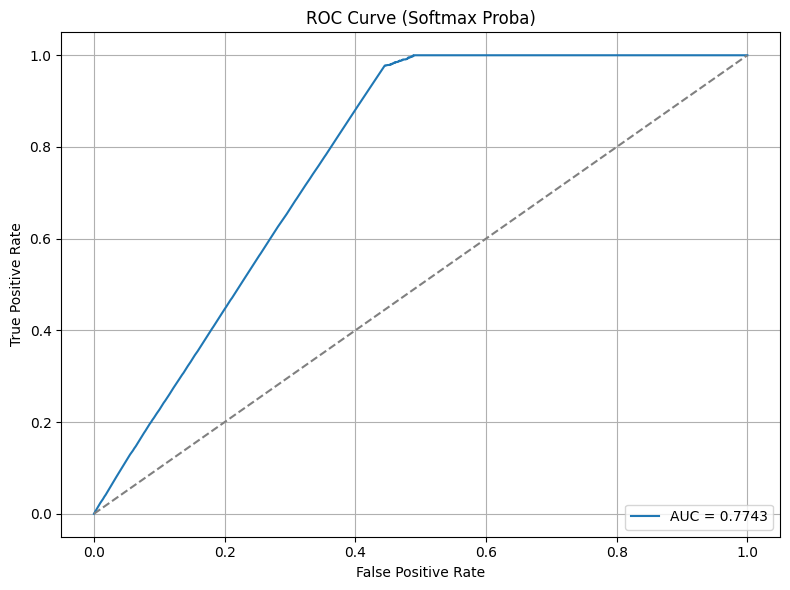

In [33]:
fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc_score = roc_auc_score(y_true, y_score)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Softmax Proba)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
joblib.dump(calibrated_model, "calibrated_model.pkl")


['calibrated_model.pkl']

In [35]:
race_df_new = pd.read_csv("../data_lightgbm/0504_race_data.csv")

In [36]:
prepared_df = race_df_new.copy()
prepared_df = prepared_df.rename(columns={
    "fav": "favorite",
    "bracket": "bracket_number"
})

In [37]:
prepared_df["avg_speed_mps"] = prepared_df["speed_mps"]
prepared_df["top3"] = 0
prepared_df["track_distance"] = 2000
prepared_df["weather_weather01"] = 1
prepared_df["weather_weather02"] = 0

In [38]:
selected_features_new = [
    "total_weight", "speed_mps", "avg_speed_mps", "favorite", "bracket_number",
    "age", "top3", "track_distance", "weather_weather01", "weather_weather02"
]

In [39]:
pairwise_rows = []
horse_names = prepared_df["Name"].values
for i_new, j_new in combinations(range(len(prepared_df)), 2):
    hi_new = prepared_df.iloc[i_new]
    hj_new = prepared_df.iloc[j_new]

    diff_ij = hi_new[selected_features_new].values - hj_new[selected_features_new].values
    pairwise_rows.append(np.concatenate([diff_ij, [i_new]]))  # i vs j

    diff_ji = hj_new[selected_features_new].values - hi_new[selected_features_new].values
    pairwise_rows.append(np.concatenate([diff_ji, [j_new]]))  # j vs i

pairwise_df_new = pd.DataFrame(pairwise_rows, columns=[f"{f}_diff" for f in selected_features_new] + ["horse_index"])
pairwise_df_new["horse_index"] = pairwise_df_new["horse_index"].astype(int)



In [40]:
X_input = pairwise_df_new.drop(columns="horse_index")
pairwise_df_new["proba"] = calibrated_model.predict_proba(X_input)[:, 1]



In [41]:
horse_scores = pairwise_df_new.groupby("horse_index")["proba"].sum().reset_index()
horse_scores["softmax_proba"] = np.exp(horse_scores["proba"]) / np.exp(horse_scores["proba"]).sum()
horse_scores["horse_name"] = horse_scores["horse_index"].apply(lambda i: horse_names[i])



In [42]:
horse_scores = horse_scores.sort_values("softmax_proba", ascending=False).reset_index(drop=True)
horse_scores.index += 1  # Rank starts from 1

print("\n🏇 Predicted Horse Rankings (Top 1 is most likely winner):\n")
print(horse_scores[["horse_name", "softmax_proba"]].to_string(index=True))


🏇 Predicted Horse Rankings (Top 1 is most likely winner):

            horse_name  softmax_proba
1             Redentor   4.271938e-01
2      Byzantine Dream   4.217879e-01
3      Shonan la Punta   9.546219e-02
4        Sunrise Earth   3.511858e-02
5       Meiner Emperor   1.291940e-02
6        Justin Palace   4.752782e-03
7       Chevalier Rose   1.748451e-03
8        Blow the Horn   6.432191e-04
9           Warp Speed   2.366271e-04
10            Pradaria   8.705025e-05
11  Hayatenofukunosuke   3.202400e-05
12          Win Erfolg   1.178097e-05
13        Limit Buster   4.333977e-06
14         Jean Kazuma   9.655986e-07
15               Arata   9.533796e-07
